## Description
This is the cross correlation calculation result. The result should show below in the first graph (ignore the first 2). You might need to invoke the cell below here to see the graph.

In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Time 0.02040816326530612
Speed of Sound 346.45
Distance 1.7676020408163264


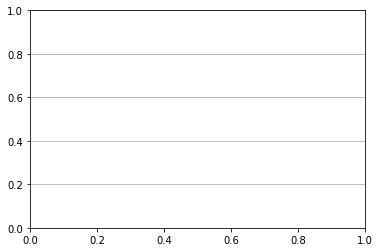

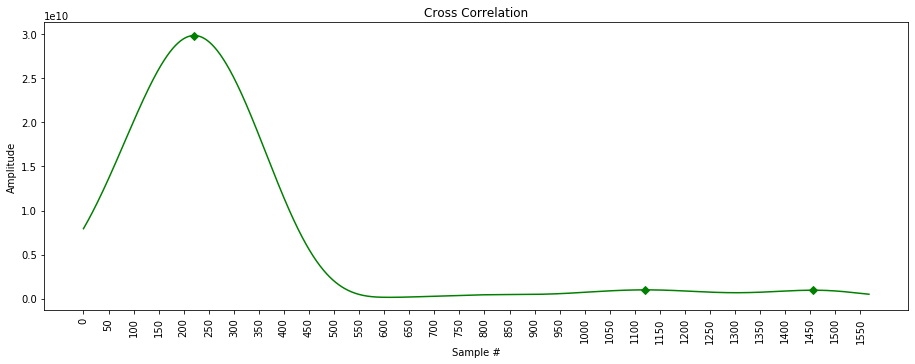

------
Time 0.02054421768707483
Speed of Sound 346.45
Distance 1.7793860544217688


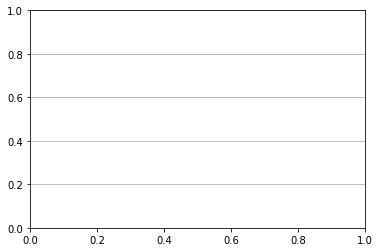

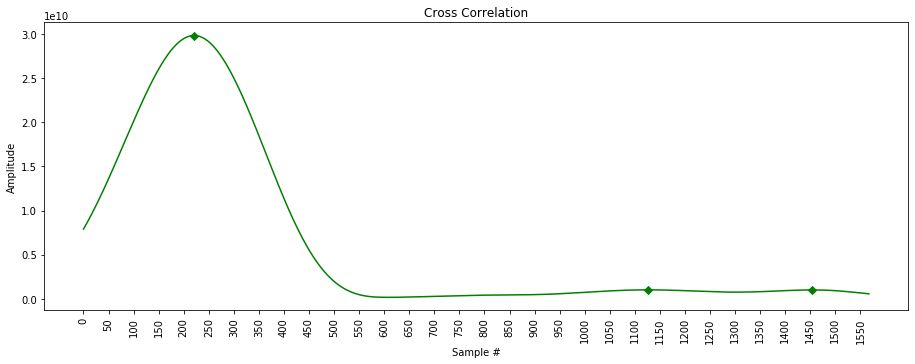

------
Time 0.020136054421768707
Speed of Sound 346.45
Distance 1.7440340136054422


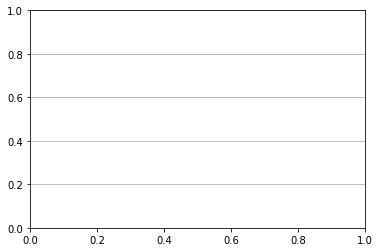

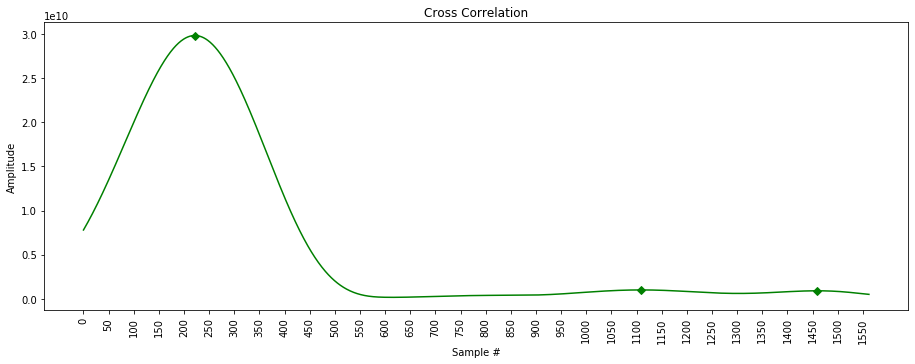

------
Time 0.02002267573696145
Speed of Sound 346.45
Distance 1.7342140022675736


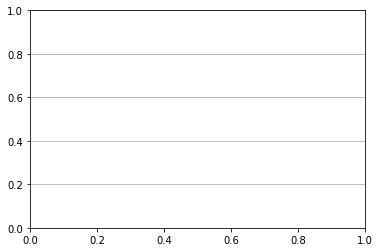

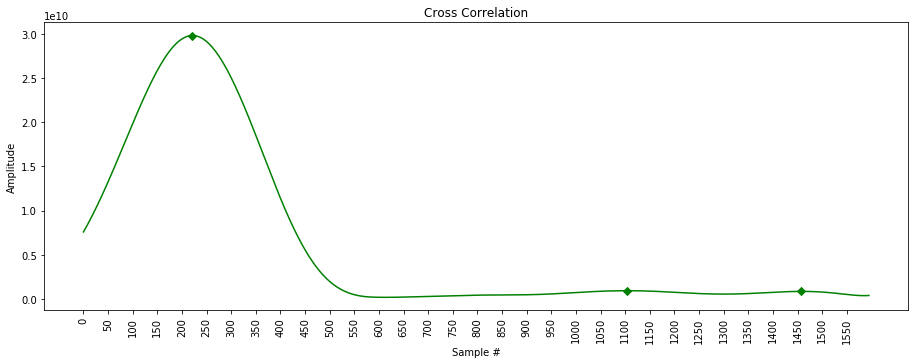

------
Time 0.020068027210884354
Speed of Sound 346.45
Distance 1.7381420068027211


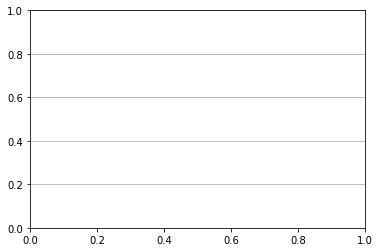

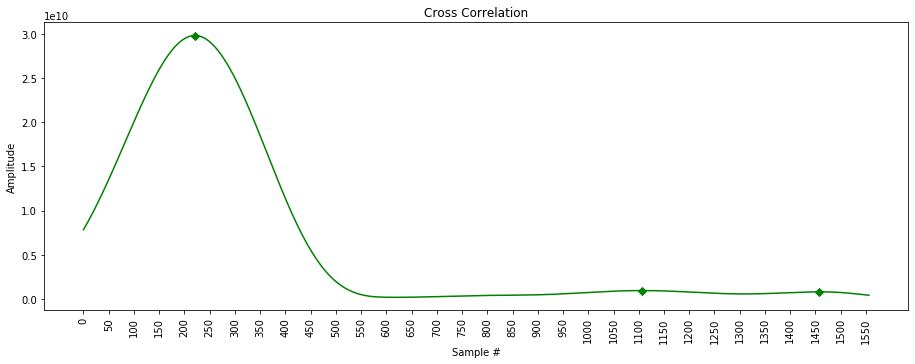

------
Time 0.02036281179138322
Speed of Sound 346.45
Distance 1.7636740362811791


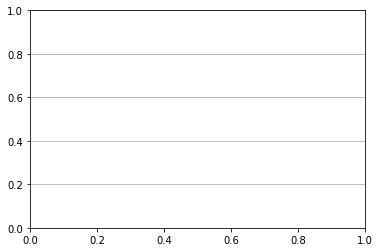

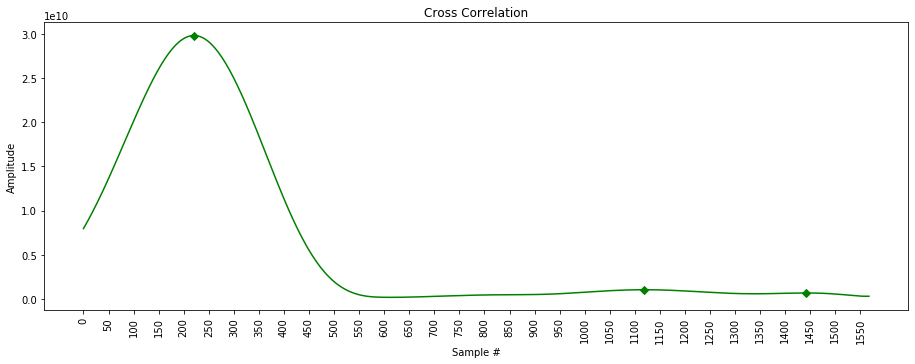

------
Time 0.020136054421768707
Speed of Sound 346.45
Distance 1.7440340136054422


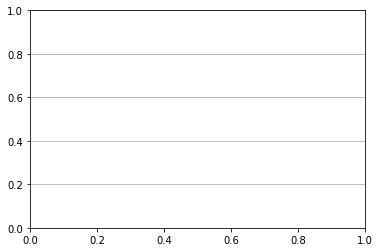

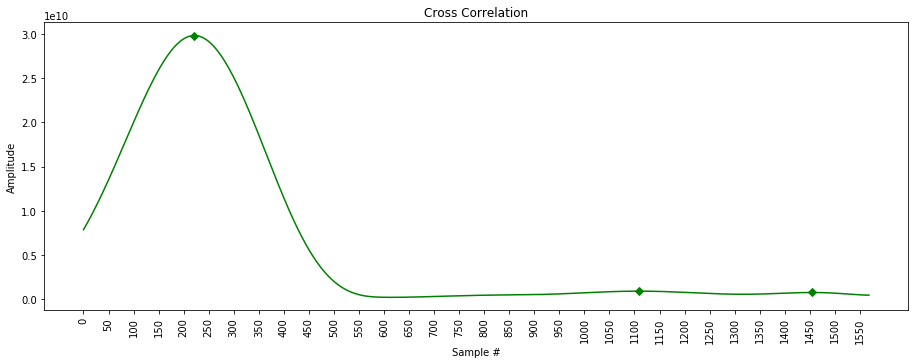

------
Time 0.020839002267573695
Speed of Sound 346.45
Distance 1.8049180839002266


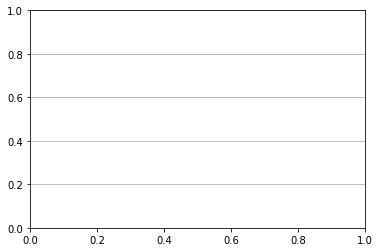

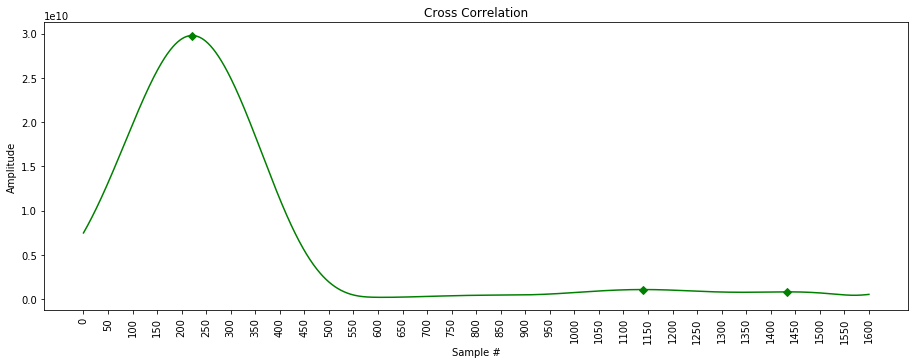

------
Time 0.02095238095238095
Speed of Sound 346.45
Distance 1.8147380952380952


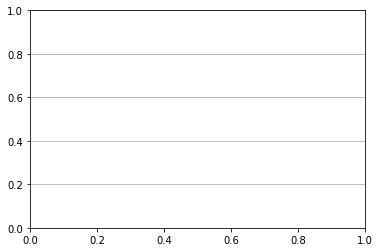

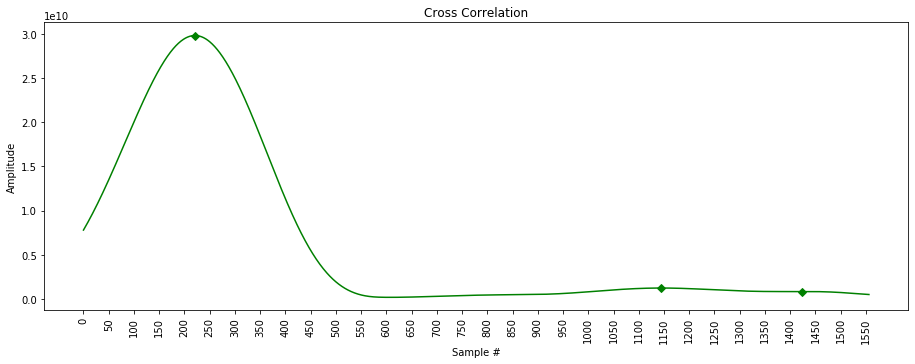

------
Time 0.020612244897959184
Speed of Sound 346.45
Distance 1.7852780612244898


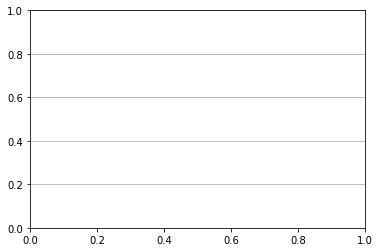

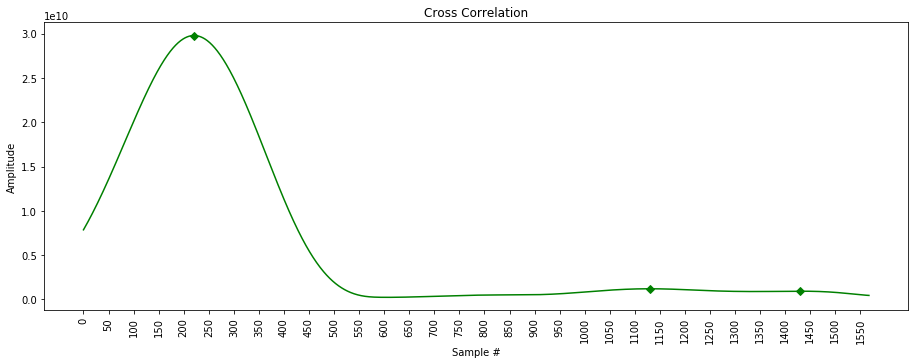

------


In [26]:
%matplotlib inline

import matplotlib.pyplot as plt
import analysis
import cross_correlation_analyzer as cca
import numpy as np
from scipy import signal

threshold = 1e4
sample_number = 1

# analysis.show_recording(sample_number)
# analysis.show_cross_correlation(sample_number)

def get_result(sample_number):
    cc = cca.main(sample_number)
    peaks = list(signal.find_peaks(cc)[0])
    time_delta = (peaks[1] - peaks[0]) / analysis.SAMPLE_RATE
    speed_of_sound = analysis.get_speed_of_sound(25)
    distance = time_delta * speed_of_sound / 2.0
    return cc, time_delta, speed_of_sound,distance/2.0, peaks

print_format = "Time {0}\nSpeed of Sound {1}\nDistance {2}"
for sample_number in range(1,11):
    cc, time_delta, speed_of_sound, half_distance, peaks = \
     get_result(sample_number)
    print(print_format.format(time_delta, speed_of_sound, half_distance))
    analysis.get_graph_figure(cc, 'Cross Correlation', markers=peaks)
    print("------")